In [9]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Tải dữ liệu đã được xử lý và feature engineering
try:
    df_featured = pd.read_csv('clean_student_data_v5.csv')
    print("Tải dữ liệu từ 'clean_student_data_v5.csv' thành công.")
    print(f"Kích thước dữ liệu: {df_featured.shape}")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file 'clean_student_data_v5.csv'.")
    df_featured = None

Tải dữ liệu từ 'clean_student_data_v5.csv' thành công.
Kích thước dữ liệu: (295000, 28)


In [10]:
# Biến mục tiêu (target variable)
TARGET_COLUMN = 'raw_score'

# Các cột không nên dùng làm feature vì gây rò rỉ dữ liệu (data leakage)
# Ví dụ: Điểm quy đổi, GPA được tính sau khi đã có điểm gốc
LEAKY_COLUMNS = ['year','raw_score', 'student_id','cumulative_gpa', 'current_semester_gpa']

# Biến đầu vào (features) là tất cả các cột còn lại
X = df_featured.drop(columns=LEAKY_COLUMNS)

# Biến mục tiêu
y = df_featured[TARGET_COLUMN]

print("Đã xác định biến đầu vào (X) và biến mục tiêu (y).")
print(f"Số lượng features: {X.shape[1]}")

Đã xác định biến đầu vào (X) và biến mục tiêu (y).
Số lượng features: 23


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% dữ liệu cho tập test
    random_state=42     # Đảm bảo kết quả chia có thể tái lập
)

print("Đã chia dữ liệu thành tập train và test.")
print("Kích thước tập huấn luyện (X_train):", X_train.shape)
print("Kích thước tập kiểm tra (X_test):", X_test.shape)

Đã chia dữ liệu thành tập train và test.
Kích thước tập huấn luyện (X_train): (236000, 23)
Kích thước tập kiểm tra (X_test): (59000, 23)


In [14]:
# Tự động xác định các cột phân loại từ tập huấn luyện
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# Tự động xác định các cột số (để đảm bảo chúng được giữ lại)
numerical_features = X_train.select_dtypes(include=np.number).columns

print(f"Các cột phân loại được xác định để One-Hot Encode: {list(categorical_features)}")
print(f"Các cột số sẽ được giữ nguyên: {list(numerical_features)}")

# Tạo một bước tiền xử lý cho các cột phân loại
# - OneHotEncoder: Chuyển đổi mỗi giá trị trong cột thành một cột nhị phân (0/1) mới.
# - handle_unknown='ignore': Nếu gặp một giá trị mới trong tập test (chưa có trong tập train), 
#   nó sẽ bỏ qua (tất cả các cột mới đều là 0) thay vì báo lỗi.
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Sử dụng ColumnTransformer để áp dụng các phép biến đổi khác nhau cho các cột khác nhau
# - transformers: Danh sách các phép biến đổi.
# - remainder='passthrough': Các cột không được chỉ định (ở đây là các cột số) sẽ được giữ nguyên.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' 
)

# Đóng gói tất cả trong một Pipeline duy nhất
# Điều này giúp ta có thể gọi .fit() và .transform() một lần cho toàn bộ quá trình
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

print("\nPipeline tiền xử lý đã được xây dựng thành công.")
display(preprocessing_pipeline)

Các cột phân loại được xác định để One-Hot Encode: ['course_code', 'study_format']
Các cột số sẽ được giữ nguyên: ['semester_number', 'credits_unit', 'previous_courses_taken', 'previous_credits_earned', 'weekly_study_hours', 'attendance_percentage', 'commute_time_minutes', 'family_support', 'study_hours_x_attendance', 'attendance_x_support', 'std_score_per_student', 'total_courses', 'num_failed_courses', 'gpa_change_rate', 'subject_type', 'expected_difficulty', 'expected_score_hint', 'avg_attendance_by_subject_type', 'fail_rate_general', 'fail_rate_major', 'attendance_gap_general_vs_major']

Pipeline tiền xử lý đã được xây dựng thành công.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['course_code', 'study_format'], dtype='object'))]))])

In [15]:
# Huấn luyện pipeline trên dữ liệu training
print("Đang huấn luyện pipeline trên X_train...")
preprocessing_pipeline.fit(X_train)
print("Huấn luyện hoàn tất.")

# Lưu pipeline đã được huấn luyện ra file joblib
pipeline_filename = 'preprocessing_pipeline.joblib'
joblib.dump(preprocessing_pipeline, pipeline_filename)

print(f"\nToàn bộ pipeline đã được lưu thành công vào file: '{pipeline_filename}'")

Đang huấn luyện pipeline trên X_train...
Huấn luyện hoàn tất.

Toàn bộ pipeline đã được lưu thành công vào file: 'preprocessing_pipeline.joblib'


In [16]:
#tái sử dụng lại
# Giả sử đây là một script khác hoặc một lần chạy sau
print("--- Thử nghiệm nạp và sử dụng lại pipeline ---")

# Tải pipeline từ file
loaded_pipeline = joblib.load(pipeline_filename)
print("Đã tải pipeline từ file.")

# Sử dụng pipeline đã tải để biến đổi dữ liệu test
# Dữ liệu test sẽ được biến đổi theo đúng cách mà dữ liệu train đã được học
X_test_transformed = loaded_pipeline.transform(X_test)

print(f"\nKích thước của X_test gốc: {X_test.shape}")
print(f"Kích thước của X_test sau khi biến đổi qua pipeline: {X_test_transformed.shape}")
print("Biến đổi thành công! Dữ liệu đã sẵn sàng để đưa vào mô hình.")

--- Thử nghiệm nạp và sử dụng lại pipeline ---
Đã tải pipeline từ file.

Kích thước của X_test gốc: (59000, 23)
Kích thước của X_test sau khi biến đổi qua pipeline: (59000, 76)
Biến đổi thành công! Dữ liệu đã sẵn sàng để đưa vào mô hình.


In [27]:
# --- 1. Cài đặt & Thư viện ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
import os

# Thư viện Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Thư viện XGBoost
import xgboost as xgb

# Cài đặt chung
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

In [28]:
# Huấn luyện pipeline trên dữ liệu training
print("Đang huấn luyện pipeline trên X_train...")
preprocessing_pipeline.fit(X_train)
print("Huấn luyện hoàn tất.")

# Lưu pipeline đã được huấn luyện ra file joblib
pipeline_filename = 'preprocessing_pipeline.joblib'
joblib.dump(preprocessing_pipeline, pipeline_filename)

print(f"\nToàn bộ pipeline đã được lưu thành công vào file: '{pipeline_filename}'")
display(preprocessing_pipeline)

Đang huấn luyện pipeline trên X_train...
Huấn luyện hoàn tất.

Toàn bộ pipeline đã được lưu thành công vào file: 'preprocessing_pipeline.joblib'


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['course_code', 'study_format'], dtype='object'))]))])

In [29]:
#tái sử dụng lại
# Giả sử đây là một script khác hoặc một lần chạy sau
print("--- Thử nghiệm nạp và sử dụng lại pipeline ---")

# Tải pipeline từ file
loaded_pipeline = joblib.load(pipeline_filename)
print("Đã tải pipeline từ file.")

# Sử dụng pipeline đã tải để biến đổi dữ liệu test
# Dữ liệu test sẽ được biến đổi theo đúng cách mà dữ liệu train đã được học
X_test_transformed = loaded_pipeline.transform(X_test)

print(f"\nKích thước của X_test gốc: {X_test.shape}")
print(f"Kích thước của X_test sau khi biến đổi qua pipeline: {X_test_transformed.shape}")
print("Biến đổi thành công! Dữ liệu đã sẵn sàng để đưa vào mô hình.")

--- Thử nghiệm nạp và sử dụng lại pipeline ---
Đã tải pipeline từ file.

Kích thước của X_test gốc: (59000, 23)
Kích thước của X_test sau khi biến đổi qua pipeline: (59000, 76)
Biến đổi thành công! Dữ liệu đã sẵn sàng để đưa vào mô hình.


In [10]:
# Định nghĩa các mô hình và lưới siêu tham số
param_grids = {
    "XGBoost": {
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.05, 0.1]
    },
    "MLPRegressor": {
        "hidden_layer_sizes": [(64, 32), (100,), (128, 64)],
        "activation": ['relu', 'tanh'],
        "alpha": [0.0001, 0.001]
    }
}

models_to_tune = {
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", random_state=42),
    "MLPRegressor": MLPRegressor(random_state=42, max_iter=1000)
}

# Thực hiện GridSearchCV
grid_search_results = []
if X_train_transformed is not None:
    for model_name, model in models_to_tune.items():
        print(f"--- Bắt đầu tinh chỉnh cho mô hình: {model_name} ---")
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[model_name],
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        grid_search.fit(X_train_transformed, y_train)
        grid_search_results.append({
            "model_name": model_name,
            "best_params": grid_search.best_params_,
            "best_cv_score_neg_mse": grid_search.best_score_
        })
    
    # Chuyển kết quả thành DataFrame
    gs_results_df = pd.DataFrame(grid_search_results)
    gs_results_df['cv_rmse'] = np.sqrt(-gs_results_df['best_cv_score_neg_mse'])
    gs_results_df.set_index('model_name', inplace=True)
if 'gs_results_df' in locals():
    print("Bảng tóm tắt kết quả GridSearchCV:")
    display(gs_results_df[['best_params', 'cv_rmse']])

--- Bắt đầu tinh chỉnh cho mô hình: XGBoost ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
--- Bắt đầu tinh chỉnh cho mô hình: MLPRegressor ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Bảng tóm tắt kết quả GridSearchCV:


best_params   cv_rmse
model_name                                                               
XGBoost       {'learning_rate': 0.05, 'max_depth': 5, 'n_est...  0.301927
MLPRegressor  {'activation': 'tanh', 'alpha': 0.001, 'hidden...  0.303532

In [11]:
if 'gs_results_df' in locals():
    evaluation_results = []
    trained_models = {}
    
    for model_name, row in gs_results_df.iterrows():
        print(f"--- Đánh giá mô hình tốt nhất của: {model_name} ---")
        best_model = models_to_tune[model_name].set_params(**row['best_params'])
        best_model.fit(X_train_transformed, y_train)
        y_pred = best_model.predict(X_test_transformed)
        
        # Lưu lại mô hình đã huấn luyện
        trained_models[model_name] = best_model
        
        # Tính toán các chỉ số
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        evaluation_results.append({
            "model_name": model_name,
            "test_mae": mae,
            "test_rmse": rmse,
            "test_r2_score": r2
        })

    eval_results_df = pd.DataFrame(evaluation_results).set_index('model_name')
if 'eval_results_df' in locals():
    print("Bảng so sánh hiệu suất các mô hình trên tập Test:")
    display(eval_results_df)

--- Đánh giá mô hình tốt nhất của: XGBoost ---
--- Đánh giá mô hình tốt nhất của: MLPRegressor ---
Bảng so sánh hiệu suất các mô hình trên tập Test:


test_mae  test_rmse  test_r2_score
model_name                                      
XGBoost       0.240927   0.301794       0.958229
MLPRegressor  0.241890   0.302849       0.957937

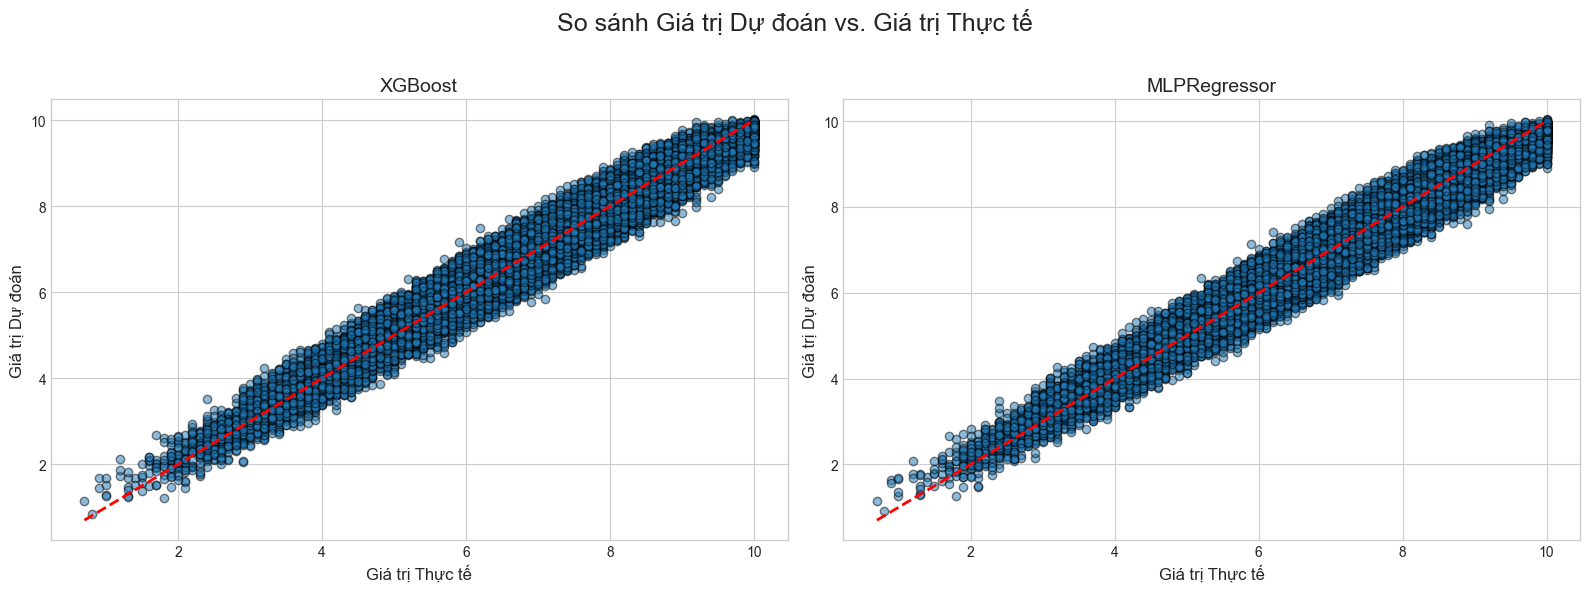

In [15]:
# Biểu đồ Scatter Plot: Thực tế vs. Dự đoán
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('So sánh Giá trị Dự đoán vs. Giá trị Thực tế', fontsize=18)

for i, (model_name, model) in enumerate(trained_models.items()):
    ax = axes[i]
    y_pred = model.predict(X_test_transformed)
    ax.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
    perfect_line = np.linspace(y_test.min(), y_test.max(), 100)
    ax.plot(perfect_line, perfect_line, 'r--', lw=2)
    ax.set_title(model_name, fontsize=14)
    ax.set_xlabel('Giá trị Thực tế', fontsize=12)
    ax.set_ylabel('Giá trị Dự đoán', fontsize=12)
    ax.grid(True)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('Scatter Plot.png')
plt.show()

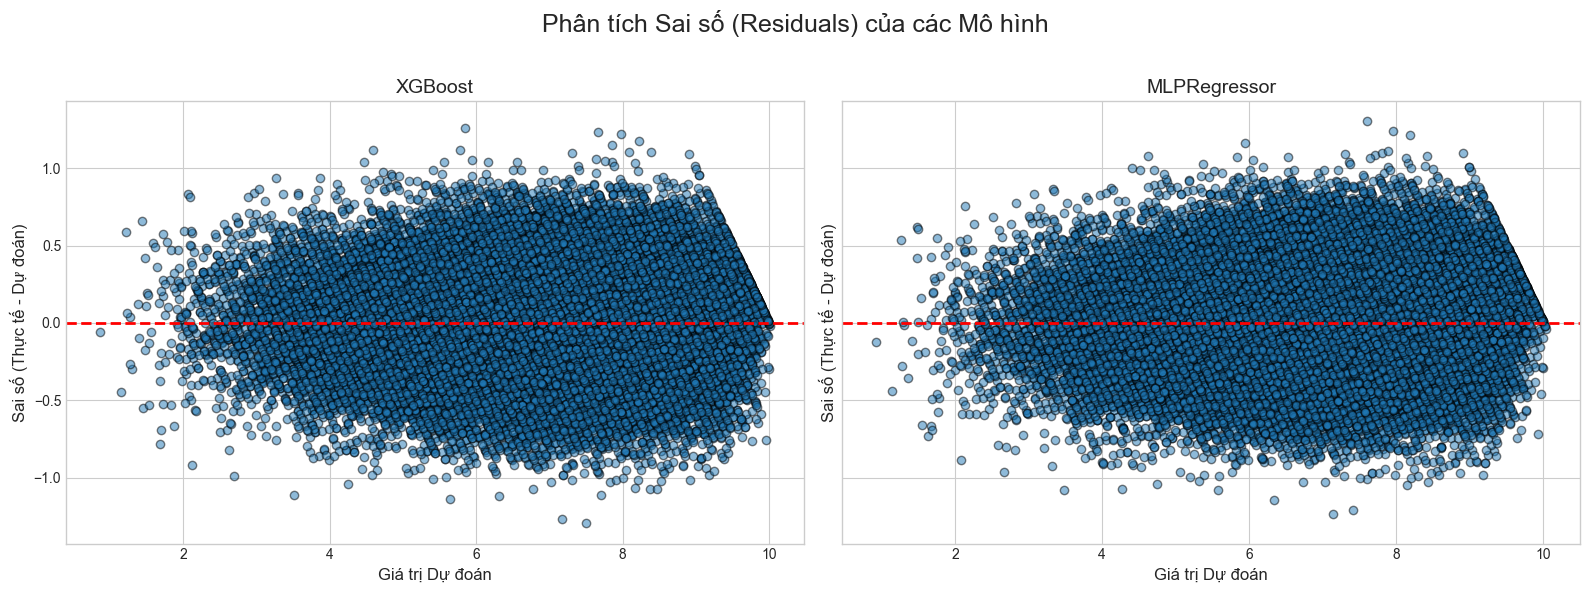

In [17]:
#Biểu đồ Residual Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle('Phân tích Sai số (Residuals) của các Mô hình', fontsize=18)

for i, (model_name, model) in enumerate(trained_models.items()):
    y_pred = model.predict(X_test_transformed)
    residuals = y_test - y_pred
    ax = axes[i]
    ax.scatter(y_pred, residuals, alpha=0.5, edgecolors='k')
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    ax.set_title(model_name, fontsize=14)
    ax.set_xlabel('Giá trị Dự đoán', fontsize=12)
    ax.set_ylabel('Sai số (Thực tế - Dự đoán)', fontsize=12)
    ax.grid(True)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('Residual Plot.png')
plt.show()

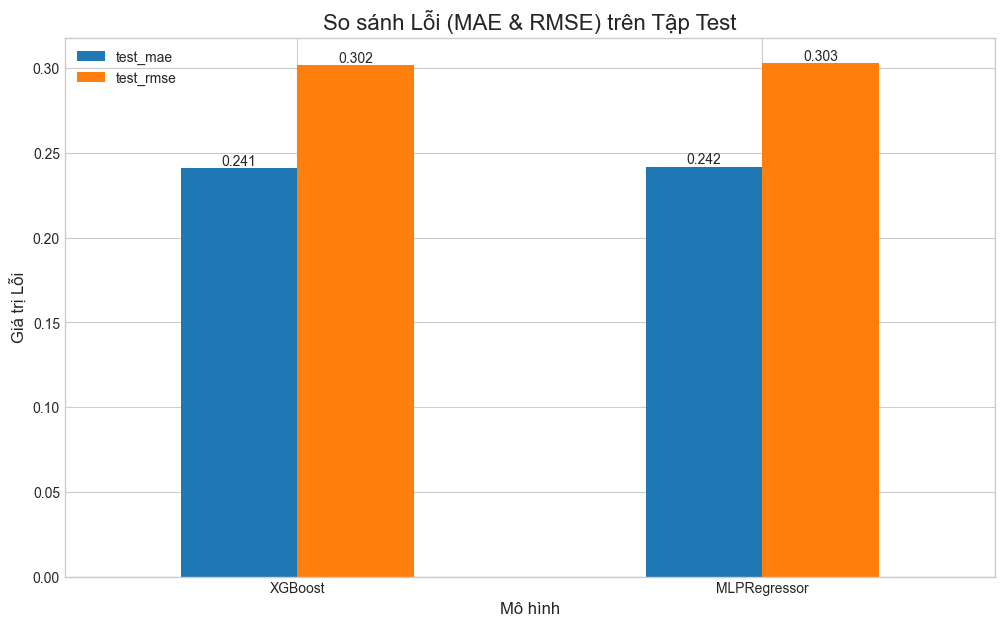

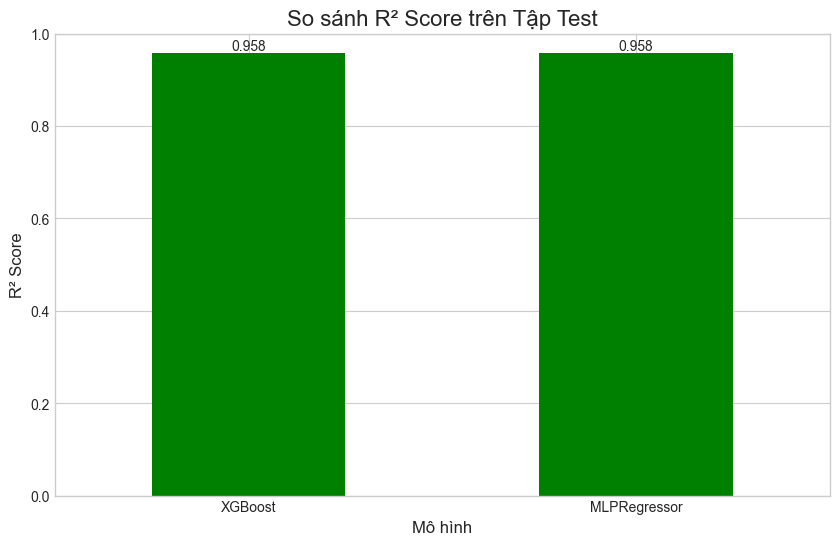

In [21]:
# Biểu đồ So sánh Hiệu suất
if 'eval_results_df' in locals():
    ax = eval_results_df[['test_mae', 'test_rmse']].plot(kind='bar', figsize=(12, 7), rot=0)
    plt.title('So sánh Lỗi (MAE & RMSE) trên Tập Test', fontsize=16)
    plt.ylabel('Giá trị Lỗi', fontsize=12)
    plt.xlabel('Mô hình', fontsize=12)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f')
    plt.savefig('MAE&RMSE.png')
    plt.show()

    ax = eval_results_df[['test_r2_score']].plot(kind='bar', figsize=(10, 6), rot=0, color='green')
    plt.title('So sánh R² Score trên Tập Test', fontsize=16)
    plt.ylabel('R² Score', fontsize=12)
    plt.xlabel('Mô hình', fontsize=12)
    ax.bar_label(ax.containers[0], fmt='%.3f')
    ax.get_legend().remove()
    plt.ylim(0, 1)
    plt.savefig('R2.png')
    plt.show()

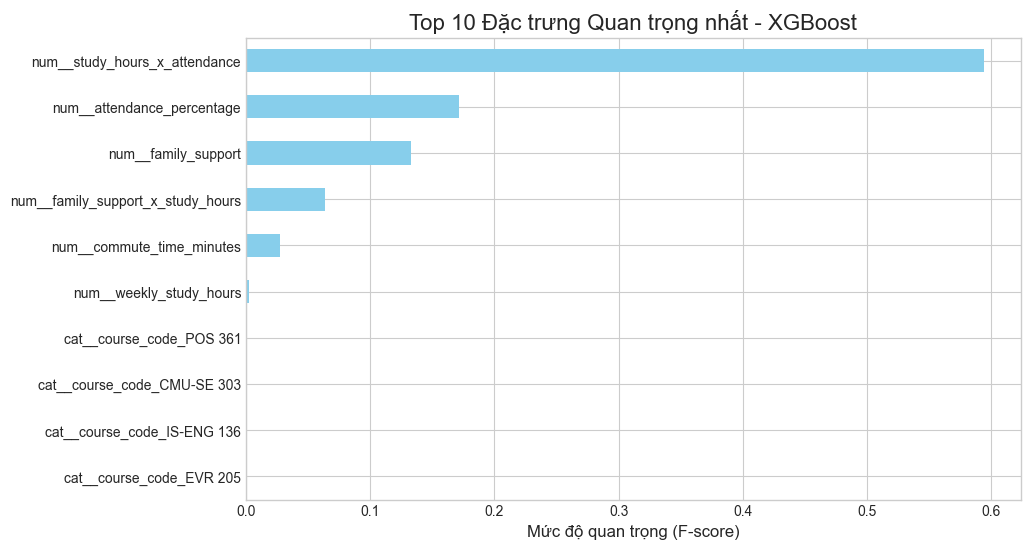

In [23]:
if 'XGBoost' in trained_models:
    model = trained_models['XGBoost']
    importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
    top_10 = importances.head(10)
    plt.figure(figsize=(10, 6))
    top_10.sort_values().plot(kind='barh', color='skyblue')
    plt.title('Top 10 Đặc trưng Quan trọng nhất - XGBoost', fontsize=16)
    plt.xlabel('Mức độ quan trọng (F-score)', fontsize=12)
    plt.savefig('XGBoostFeatureImportance.png')
    plt.show()

Đang tính Permutation Importance cho MLP Regressor...


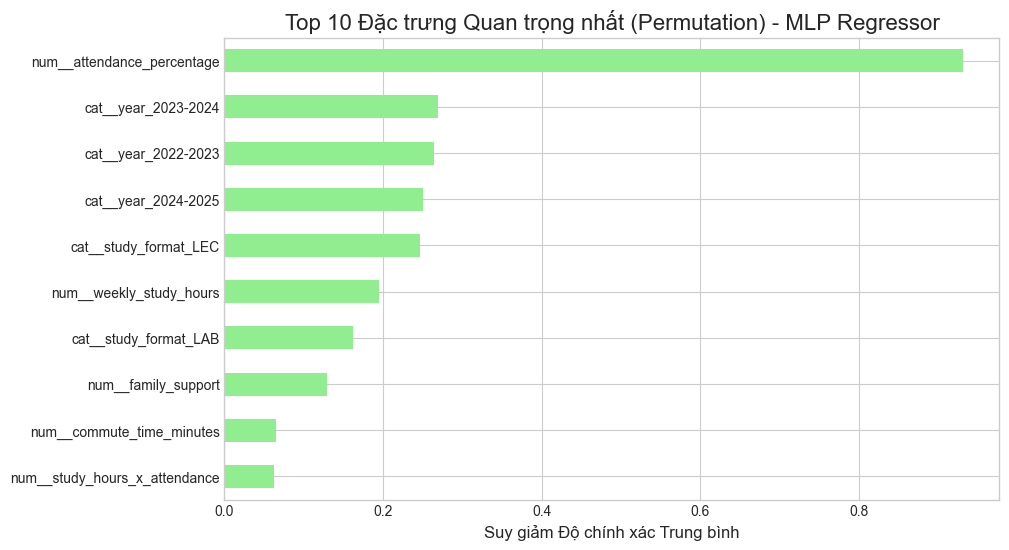

In [24]:
if 'MLPRegressor' in trained_models:
    model = trained_models['MLPRegressor']
    print("Đang tính Permutation Importance cho MLP Regressor...")
    result = permutation_importance(
        model, X_test_transformed, y_test, n_repeats=10, random_state=42, n_jobs=-1
    )
    perm_importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)
    top_10 = perm_importances.head(10)
    plt.figure(figsize=(10, 6))
    top_10.sort_values().plot(kind='barh', color='lightgreen')
    plt.title('Top 10 Đặc trưng Quan trọng nhất (Permutation) - MLP Regressor', fontsize=16)
    plt.xlabel('Suy giảm Độ chính xác Trung bình', fontsize=12)
    plt.savefig('MLPRegressorPermutationImportance.png')
    plt.show()

Tải dữ liệu từ 'clean_student_data_v5.csv' thành công.
Đã chia dữ liệu: 236000 mẫu huấn luyện, 59000 mẫu kiểm tra.
Dữ liệu đã được mã hóa và chuẩn hóa. Kích thước X_train mới: (236000, 76)

--- 🚀 Bắt đầu tối ưu mô hình XGBoost ---
Fitting 5 folds for each of 81 candidates, totalling 405 fits

✅ Các tham số XGBoost tốt nhất tìm được: {'colsample_bytree': 0.6, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 1.0}
--- Huấn luyện mô hình XGBoost cuối cùng với Early Stopping ---

--- 🚀 Bắt đầu tối ưu mô hình MLPRegressor ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits

✅ Các tham số MLPRegressor tốt nhất tìm được: {'alpha': 0.0001, 'hidden_layer_sizes': (256, 128, 64), 'learning_rate_init': 0.01, 'solver': 'adam'}

--- 📊 Đánh giá độ chính xác trên tập Test ---
Kết quả cho XGBoost Tối ưu:
  - MAE: 0.2402
  - RMSE: 0.3010
  - R² Score: 0.9585

Kết quả cho MLPRegressor Tối ưu:
  - MAE: 0.2417
  - RMSE: 0.3026
  - R² Score: 0.9580



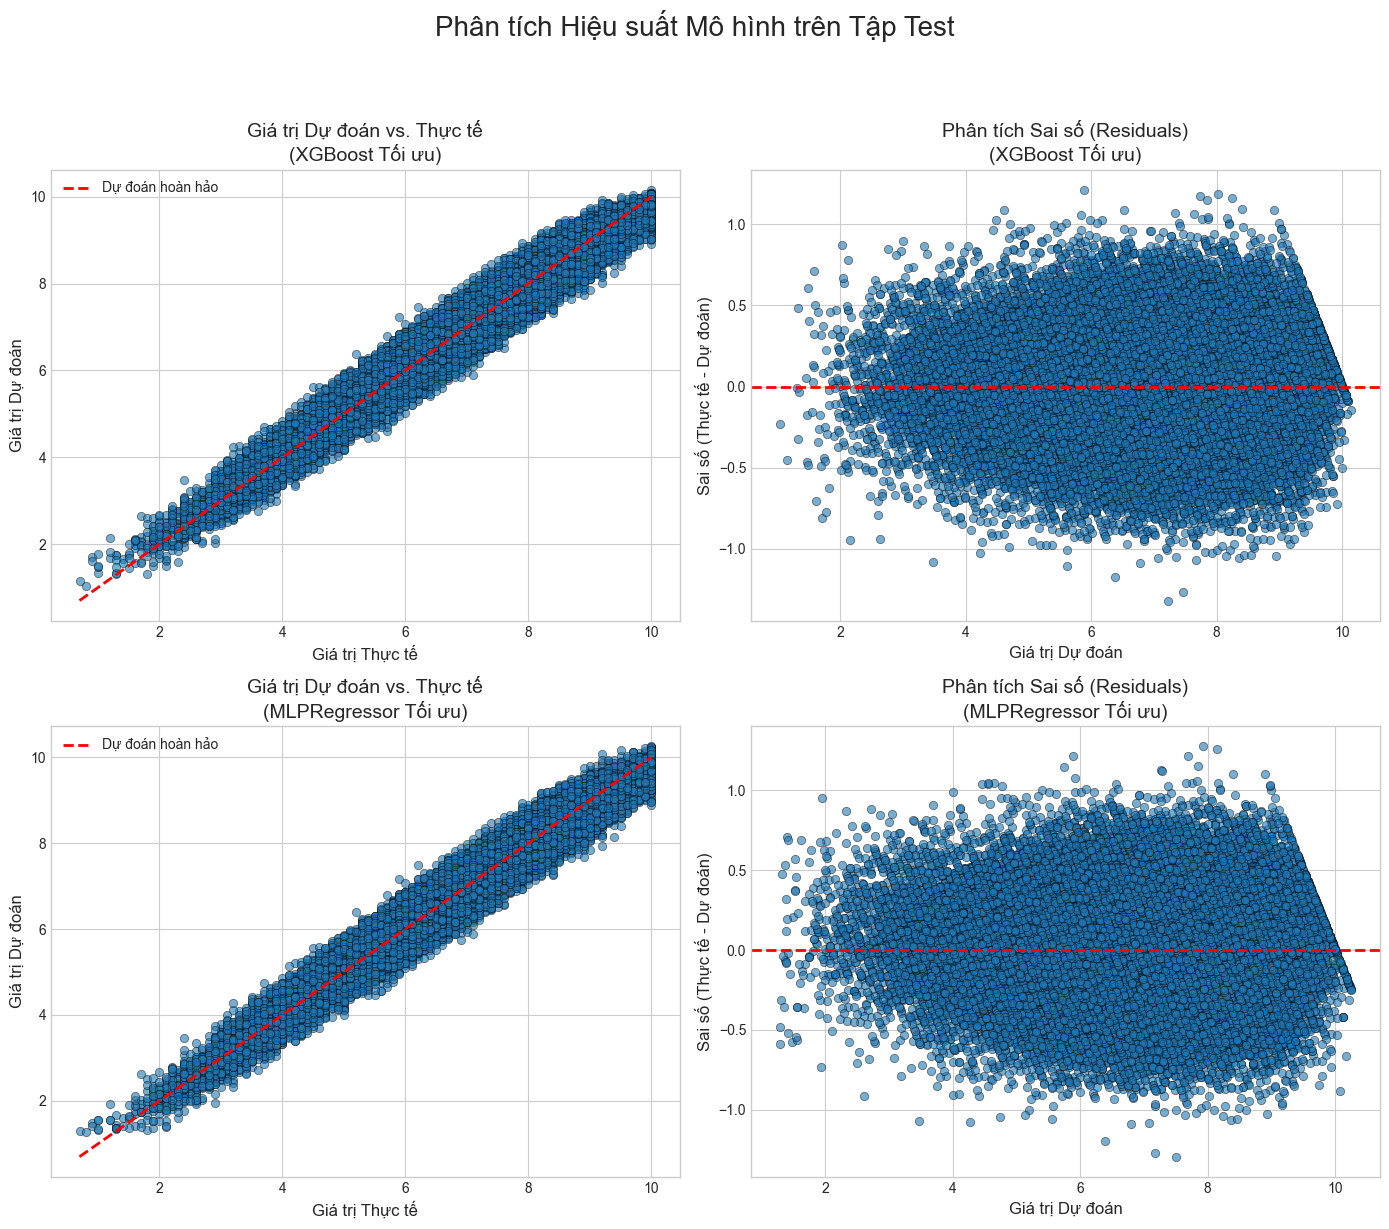

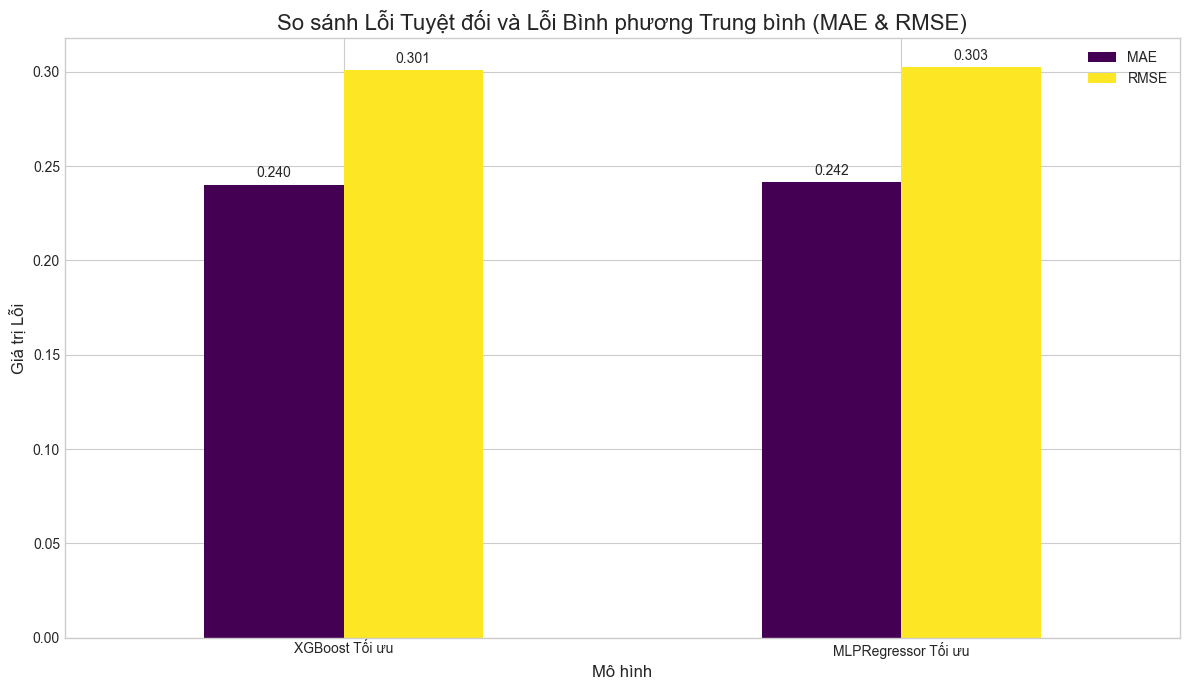

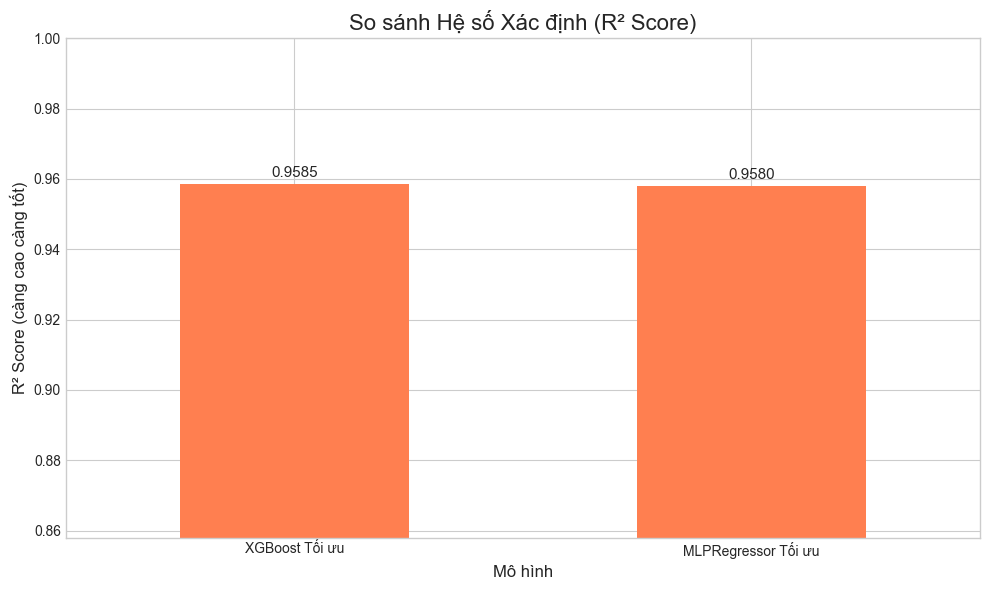


--- 📋 Bảng tổng kết so sánh hiệu suất ---


In [30]:
# === PHẦN 0: CÀI ĐẶT & THƯ VIỆN ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display

# Thư viện Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Thư viện XGBoost
import xgboost as xgb

# Cài đặt chung
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'


# === PHẦN 1: TẢI VÀ TIỀN XỬ LÝ DỮ LIỆU ===
data_loaded_successfully = False
try:
    df = pd.read_csv('clean_student_data_v5.csv')
    print("Tải dữ liệu từ 'clean_student_data_v5.csv' thành công.")
    TARGET_COLUMN = 'raw_score'
    DROP_COLUMNS = ['year','raw_score', 'student_id','cumulative_gpa', 'current_semester_gpa']
    X = df.drop(columns=DROP_COLUMNS)
    y = df[TARGET_COLUMN]
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Đã chia dữ liệu: {X_train_raw.shape[0]} mẫu huấn luyện, {X_test_raw.shape[0]} mẫu kiểm tra.")
    
    categorical_features = X_train_raw.select_dtypes(include=['object', 'category']).columns
    numerical_features = X_train_raw.select_dtypes(include=np.number).columns
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    numerical_transformer = StandardScaler()
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ],
        remainder='passthrough'
    )
    X_train = preprocessor.fit_transform(X_train_raw)
    X_test = preprocessor.transform(X_test_raw)
    feature_names = preprocessor.get_feature_names_out()
    print(f"Dữ liệu đã được mã hóa và chuẩn hóa. Kích thước X_train mới: {X_train.shape}")
    data_loaded_successfully = True

except FileNotFoundError:
    print("\nLỖI: Không tìm thấy file 'clean_student_data_v3.csv'.\n")

# === TOÀN BỘ QUY TRÌNH HUẤN LUYỆN CHỈ CHẠY KHI DỮ LIỆU TẢI THÀNH CÔNG ===
if data_loaded_successfully:
    # === PHẦN 2: CẢI TIẾN VÀ HUẤN LUYỆN MÔ HÌNH ===
    print("\n--- 🚀 Bắt đầu tối ưu mô hình XGBoost ---")
    param_grid_xgb = {
        'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.1, 1], 'reg_lambda': [1, 10, 100]
    }
    xgb_model_base = xgb.XGBRegressor(
        objective='reg:squarederror', learning_rate=0.05, max_depth=5,
        random_state=42, n_jobs=-1, n_estimators=500
    )
    grid_search_xgb = GridSearchCV(
        estimator=xgb_model_base, param_grid=param_grid_xgb, cv=5,
        scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1
    )
    grid_search_xgb.fit(X_train, y_train)
    print(f"\n✅ Các tham số XGBoost tốt nhất tìm được: {grid_search_xgb.best_params_}")
    
    print("--- Huấn luyện mô hình XGBoost cuối cùng với Early Stopping ---")
    best_xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror', n_estimators=1000, learning_rate=0.05,
        max_depth=5, random_state=42, n_jobs=-1,
        early_stopping_rounds=20, **grid_search_xgb.best_params_
    )
    best_xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    print("\n--- 🚀 Bắt đầu tối ưu mô hình MLPRegressor ---")
    param_grid_mlp = {
        'hidden_layer_sizes': [(128,), (128, 64), (256, 128, 64)],
        'solver': ['adam'], 'learning_rate_init': [0.001, 0.01], 'alpha': [0.0001, 0.001]
    }
    mlp_model_base = MLPRegressor(random_state=42, max_iter=1000, early_stopping=True)
    grid_search_mlp = GridSearchCV(
        estimator=mlp_model_base, param_grid=param_grid_mlp, cv=5,
        scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1
    )
    grid_search_mlp.fit(X_train, y_train)
    best_mlp_model = grid_search_mlp.best_estimator_
    print(f"\n✅ Các tham số MLPRegressor tốt nhất tìm được: {grid_search_mlp.best_params_}")

    # === PHẦN 3: ĐÁNH GIÁ ĐỘ CHÍNH XÁC SAU TỐI ƯU ===
    print("\n--- 📊 Đánh giá độ chính xác trên tập Test ---")
    trained_models = {
        "XGBoost Tối ưu": best_xgb_model, "MLPRegressor Tối ưu": best_mlp_model
    }
    evaluation_results = []
    for model_name, model in trained_models.items():
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        
        # SỬA LỖI: Thay thế cách tính RMSE để tương thích với mọi phiên bản sklearn
        # Dòng mã cũ: rmse = mean_squared_error(y_test, y_pred, squared=False)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        r2 = r2_score(y_test, y_pred)
        evaluation_results.append({"Mô hình": model_name, "MAE": mae, "RMSE": rmse, "R² Score": r2})
        print(f"Kết quả cho {model_name}:\n  - MAE: {mae:.4f}\n  - RMSE: {rmse:.4f}\n  - R² Score: {r2:.4f}\n")
    eval_df = pd.DataFrame(evaluation_results)

    # === PHẦN 4: BIỂU DIỄN KẾT QUẢ TRỰC QUAN ===
    # (Phần này không thay đổi, giữ nguyên như cũ)
    n_models = len(trained_models)
    fig, axes = plt.subplots(n_models, 2, figsize=(14, 6 * n_models), squeeze=False)
    fig.suptitle('Phân tích Hiệu suất Mô hình trên Tập Test', fontsize=20, y=1.02)
    for i, (model_name, model) in enumerate(trained_models.items()):
        y_pred = model.predict(X_test)
        residuals = y_test - y_pred
        ax_scatter = axes[i, 0]
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, ax=ax_scatter, edgecolor='k')
        perfect_line = np.linspace(min(y_test), max(y_test), 100)
        ax_scatter.plot(perfect_line, perfect_line, 'r--', lw=2, label='Dự đoán hoàn hảo')
        ax_scatter.set_title(f'Giá trị Dự đoán vs. Thực tế\n({model_name})', fontsize=14)
        ax_scatter.set_xlabel('Giá trị Thực tế', fontsize=12)
        ax_scatter.set_ylabel('Giá trị Dự đoán', fontsize=12)
        ax_scatter.legend()
        ax_scatter.grid(True)
        ax_residual = axes[i, 1]
        sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, ax=ax_residual, edgecolor='k')
        ax_residual.axhline(y=0, color='r', linestyle='--', lw=2)
        ax_residual.set_title(f'Phân tích Sai số (Residuals)\n({model_name})', fontsize=14)
        ax_residual.set_xlabel('Giá trị Dự đoán', fontsize=12)
        ax_residual.set_ylabel('Sai số (Thực tế - Dự đoán)', fontsize=12)
        ax_residual.grid(True)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    eval_df.set_index('Mô hình', inplace=True)
    ax1 = eval_df[['MAE', 'RMSE']].plot(kind='bar', figsize=(12, 7), rot=0, colormap='viridis')
    ax1.set_title('So sánh Lỗi Tuyệt đối và Lỗi Bình phương Trung bình (MAE & RMSE)', fontsize=16)
    ax1.set_ylabel('Giá trị Lỗi', fontsize=12)
    ax1.set_xlabel('Mô hình', fontsize=12)
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.3f', fontsize=10, padding=3)
    plt.tight_layout()
    plt.show()

    ax2 = eval_df[['R² Score']].plot(kind='bar', figsize=(10, 6), rot=0, color='coral', legend=False)
    ax2.set_title('So sánh Hệ số Xác định (R² Score)', fontsize=16)
    ax2.set_ylabel('R² Score (càng cao càng tốt)', fontsize=12)
    ax2.set_xlabel('Mô hình', fontsize=12)
    ax2.set_ylim(bottom=max(0, eval_df['R² Score'].min() - 0.1), top=1.0)
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.4f', fontsize=11, padding=3)
    plt.tight_layout()
    plt.show()

    # === PHẦN 5: HIỂN THỊ BẢNG SO SÁNH CUỐI CÙNG ===
    print("\n--- 📋 Bảng tổng kết so sánh hiệu suất ---")
    display(eval_df.style.format("{:.4f}").highlight_min(
        subset=['MAE', 'RMSE'], color='#c8e6c9'
    ).highlight_max(
        subset=['R² Score'], color='#c8e6c9'
    ))

In [31]:
# ===================================================================
# === PHẦN 6: LƯU VÀ KIỂM TRA PIPELINE HOÀN CHỈNH                 ===
# ===================================================================
print("\n--- 💾 Bắt đầu lưu và kiểm tra pipeline hoàn chỉnh ---")

    # --- 6.1. Kết hợp preprocessor và model thành một pipeline duy nhất ---
    # `preprocessor` là đối tượng ColumnTransformer đã được fit ở Phần 1
    # `best_xgb_model` và `best_mlp_model` là các mô hình đã được huấn luyện ở Phần 2
    
print("   -> Đang tạo các pipeline hoàn chỉnh (preprocessor + model)...")
xgb_full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_xgb_model)
])

mlp_full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_mlp_model)
])
print("   -> Tạo pipeline hoàn chỉnh thành công.")

# --- 6.2. Lưu các pipeline hoàn chỉnh vào file .joblib ---
xgb_filename = "xgb_final_pipeline.joblib"
mlp_filename = "mlp_final_pipeline.joblib"

joblib.dump(xgb_full_pipeline, xgb_filename)
print(f"   -> Đã lưu pipeline XGBoost vào file: '{xgb_filename}'")
    
joblib.dump(mlp_full_pipeline, mlp_filename)
print(f"   -> Đã lưu pipeline MLPRegressor vào file: '{mlp_filename}'")

# --- 6.3. Kiểm tra lại các file đã lưu để đảm bảo tính toàn vẹn ---
print("\n--- 🔍 Bắt đầu kiểm tra lại các file đã lưu ---")
    
# Tải lại và kiểm tra pipeline của XGBoost
try:
    loaded_xgb_pipeline = joblib.load(xgb_filename)
    # Quan trọng: Dự đoán trên dữ liệu thô (X_test_raw) để kiểm tra toàn bộ pipeline
    xgb_preds_from_loaded = loaded_xgb_pipeline.predict(X_test_raw)
    r2_loaded_xgb = r2_score(y_test, xgb_preds_from_loaded)
        
    print(f"   -> Tải và kiểm tra '{xgb_filename}' thành công.")
    print(f"      R² Score từ pipeline đã tải: {r2_loaded_xgb:.4f}")
        
    # So sánh với kết quả đã tính toán ở Phần 3
    original_r2_xgb = eval_df.loc['XGBoost Tối ưu', 'R² Score']
    assert np.isclose(r2_loaded_xgb, original_r2_xgb), "R² Score không khớp!"
    print("      Kết quả khớp với mô hình gốc. Toàn vẹn dữ liệu được đảm bảo.")

except Exception as e:
    print(f"   -> LỖI khi kiểm tra file XGBoost: {e}")

    # Tải lại và kiểm tra pipeline của MLPRegressor
try:
    loaded_mlp_pipeline = joblib.load(mlp_filename)
    # Quan trọng: Dự đoán trên dữ liệu thô (X_test_raw)
    mlp_preds_from_loaded = loaded_mlp_pipeline.predict(X_test_raw)
    r2_loaded_mlp = r2_score(y_test, mlp_preds_from_loaded)
    
    print(f"\n   -> Tải và kiểm tra '{mlp_filename}' thành công.")
    print(f"      R² Score từ pipeline đã tải: {r2_loaded_mlp:.4f}")

    # So sánh với kết quả đã tính toán ở Phần 3
    original_r2_mlp = eval_df.loc['MLPRegressor Tối ưu', 'R² Score']
    assert np.isclose(r2_loaded_mlp, original_r2_mlp), "R² Score không khớp!"
    print("      Kết quả khớp với mô hình gốc. Toàn vẹn dữ liệu được đảm bảo.")

except Exception as e:
    print(f"   -> LỖI khi kiểm tra file MLPRegressor: {e}")


--- 💾 Bắt đầu lưu và kiểm tra pipeline hoàn chỉnh ---
   -> Đang tạo các pipeline hoàn chỉnh (preprocessor + model)...
   -> Tạo pipeline hoàn chỉnh thành công.
   -> Đã lưu pipeline XGBoost vào file: 'xgb_final_pipeline.joblib'
   -> Đã lưu pipeline MLPRegressor vào file: 'mlp_final_pipeline.joblib'

--- 🔍 Bắt đầu kiểm tra lại các file đã lưu ---
   -> Tải và kiểm tra 'xgb_final_pipeline.joblib' thành công.
      R² Score từ pipeline đã tải: 0.9585
      Kết quả khớp với mô hình gốc. Toàn vẹn dữ liệu được đảm bảo.

   -> Tải và kiểm tra 'mlp_final_pipeline.joblib' thành công.
      R² Score từ pipeline đã tải: 0.9580
      Kết quả khớp với mô hình gốc. Toàn vẹn dữ liệu được đảm bảo.


In [32]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import numpy as np                                  # dùng cho np.isclose

# ------------------------------------------------------------------
# 1️⃣ NẠP PREPROCESSOR ĐÃ LƯU
# ------------------------------------------------------------------
preprocessor = joblib.load("preprocessing_pipeline.joblib")
print("✅ Đã nạp preprocessing pipeline từ file.")


✅ Đã nạp preprocessing pipeline từ file.


In [33]:
# ------------------------------------------------------------------
# 4️⃣ KIỂM TRA LẠI FILE ĐÃ LƯU
# ------------------------------------------------------------------
loaded_xgb = joblib.load("xgb_final_pipeline.joblib")
loaded_mlp = joblib.load("mlp_final_pipeline.joblib")

# X_test_raw là features CHƯA qua bất kỳ transform nào
xgb_pred = loaded_xgb.predict(X_test_raw)
mlp_pred = loaded_mlp.predict(X_test_raw)

r2_xgb_loaded = r2_score(y_test, xgb_pred)
r2_mlp_loaded = r2_score(y_test, mlp_pred)

print(f"🔍 R² XGB (đã load): {r2_xgb_loaded:.4f}")
print(f"🔍 R² MLP (đã load): {r2_mlp_loaded:.4f}")

# So khớp với bảng eval_df đã tính trước
assert np.isclose(
    r2_xgb_loaded, eval_df.loc["XGBoost Tối ưu", "R² Score"]
), "❌ R² của XGB không khớp!"
assert np.isclose(
    r2_mlp_loaded, eval_df.loc["MLPRegressor Tối ưu", "R² Score"]
), "❌ R² của MLP không khớp!"

print("✅ Kiểm tra toàn vẹn thành công – Kết quả khớp mô hình gốc.")


🔍 R² XGB (đã load): 0.9585
🔍 R² MLP (đã load): 0.9580
✅ Kiểm tra toàn vẹn thành công – Kết quả khớp mô hình gốc.



--- 🔍 Top 10 đặc trưng quan trọng nhất của mô hình XGBoost ---


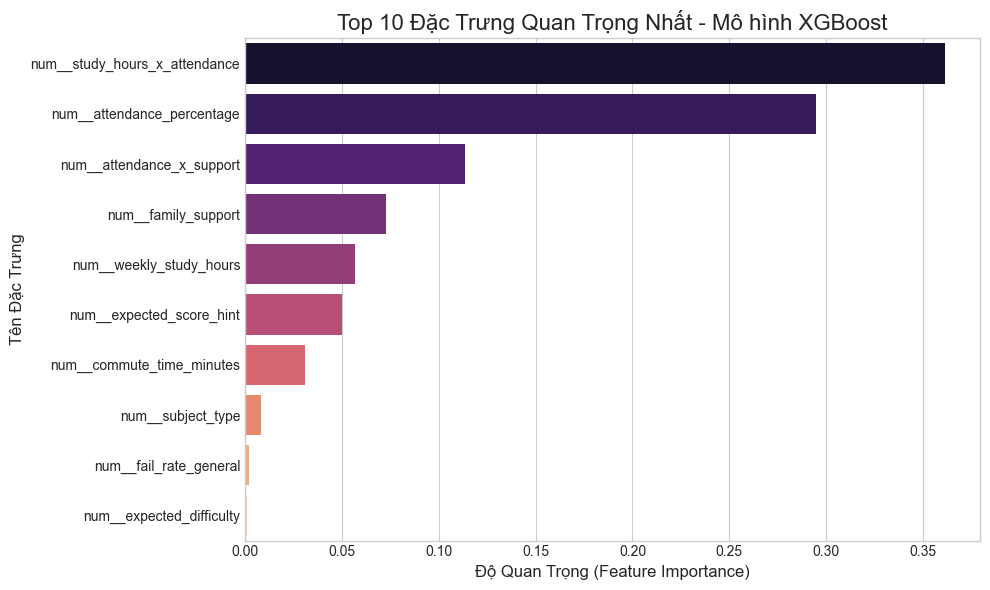

In [34]:
# === PHẦN 6: TOP 10 ĐẶC TRƯNG QUAN TRỌNG NHẤT CỦA XGBOOST ===
importances = best_xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Hiển thị bảng
print("\n--- 🔍 Top 10 đặc trưng quan trọng nhất của mô hình XGBoost ---")
display(top_features.style.format({"Importance": "{:.4f}"}))

# Biểu đồ trực quan
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature', palette='magma')
plt.title('Top 10 Đặc Trưng Quan Trọng Nhất - Mô hình XGBoost', fontsize=16)
plt.xlabel('Độ Quan Trọng (Feature Importance)', fontsize=12)
plt.ylabel('Tên Đặc Trưng', fontsize=12)
plt.tight_layout()
plt.savefig('XGBoostPermutationImportancev1.png')
plt.show()


In [26]:
print(X_test.dtypes)

semester_number                      int64
course_code                         object
study_format                        object
credits_unit                         int64
previous_courses_taken               int64
previous_credits_earned              int64
weekly_study_hours                   int64
attendance_percentage              float64
commute_time_minutes                 int64
family_support                       int64
study_hours_x_attendance           float64
attendance_x_support               float64
std_score_per_student              float64
total_courses                        int64
num_failed_courses                   int64
gpa_change_rate                    float64
subject_type                         int64
expected_difficulty                  int64
expected_score_hint                  int64
avg_attendance_by_subject_type     float64
fail_rate_general                  float64
fail_rate_major                    float64
attendance_gap_general_vs_major    float64
dtype: obje


--- 🔍 Tính Permutation Importance cho MLPRegressor ---
--- 🔍 Top 10 đặc trưng quan trọng nhất của mô hình MLPRegressor ---


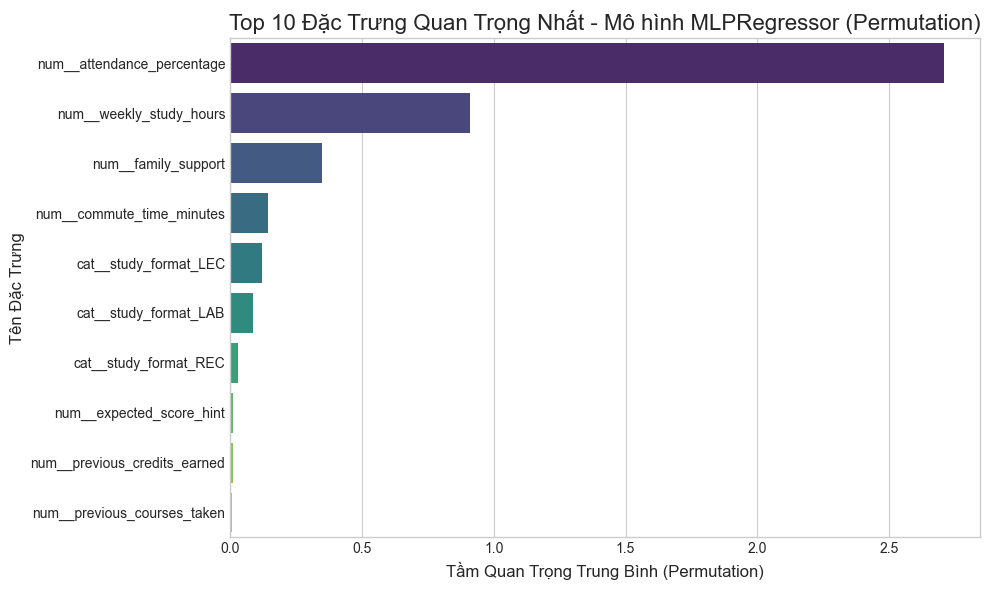

In [35]:
from sklearn.inspection import permutation_importance

# Tính Permutation Importance trên tập kiểm tra
print("\n--- 🔍 Tính Permutation Importance cho MLPRegressor ---")
perm_result = permutation_importance(
    best_mlp_model, X_test, y_test, n_repeats=10,
    random_state=42, n_jobs=-1, scoring='neg_mean_squared_error'
)

# Lưu lại kết quả dưới dạng DataFrame
mlp_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_result.importances_mean
})
top_mlp_features = mlp_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Hiển thị bảng
print("--- 🔍 Top 10 đặc trưng quan trọng nhất của mô hình MLPRegressor ---")
display(top_mlp_features.style.format({"Importance": "{:.4f}"}))

# Biểu đồ trực quan
plt.figure(figsize=(10, 6))
sns.barplot(data=top_mlp_features, x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Đặc Trưng Quan Trọng Nhất - Mô hình MLPRegressor (Permutation)', fontsize=16)
plt.xlabel('Tầm Quan Trọng Trung Bình (Permutation)', fontsize=12)
plt.ylabel('Tên Đặc Trưng', fontsize=12)
plt.tight_layout()
plt.savefig('MLPRegressorPermutationImportancev1.png')
plt.show()


In [12]:
!nvidia-smi

Sun Jun 29 18:31:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.52                 Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P0             16W /   75W |     416MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
     -------------------------------------- 536.2/536.2 kB 8.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 GB 12.7 MB/s eta 0:03:43
   ---------------------------------------- 0.0/2.8 GB 19.6 MB/s eta 0:02:24
   ---------------------------------------- 0.0/2.8 GB 31.3 MB/s eta 0:01:30
   ---------------------------------------- 0.0/2.8 GB 33.5 MB/s eta 0:01:24
   ---------------------------------------- 0.0/2.8 GB 36.5 MB/s eta 0:01:17
    --------------------------------------- 0.0/2.8 GB 38.1 MB/s eta 0:01:13
    --------------------------------------- 0.1/2.8 GB 39.2 MB/s eta 0:01:11
    --------------------------------------- 0.1/2.8 GB 40.5 MB/s eta 0:01:08
    --------------------------------------- 0.1/2.8 GB 41.1 MB/s eta 0:01:07
   - ---------------------

In [36]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ==== Dataset từ numpy ====
class StudentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values if hasattr(y, 'values') else y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ==== Mạng nơ-ron hồi quy đơn giản ====
class SimpleRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# ==== Mạng nơ-ron đa nhiệm (Multi-output) ====
class MultitaskResNet(nn.Module):
    def __init__(self, input_dim):
        super(MultitaskResNet, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.out1 = nn.Linear(64, 1)  # Task 1: raw_score
        self.out2 = nn.Linear(64, 1)  # Task 2: GPA hoặc đầu ra phụ

    def forward(self, x):
        x = self.shared(x)
        return self.out1(x), self.out2(x)

# ==== Hàm huấn luyện hỗ trợ cả mô hình đơn và đa nhiệm ====
def train_model(model, train_loader, val_loader, epochs=20, lr=0.001, multitask=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"➡️ Đang huấn luyện trên: {device}")

    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            if multitask:
                out1, _ = model(X_batch)
                loss = criterion(out1, y_batch)
            else:
                preds = model(X_batch)
                loss = criterion(preds, y_batch)

            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                if multitask:
                    out1, _ = model(X_val)
                    val_loss += criterion(out1, y_val).item() * X_val.size(0)
                else:
                    preds = model(X_val)
                    val_loss += criterion(preds, y_val).item() * X_val.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


In [37]:
# Tạo DataLoader từ dữ liệu đã transform (sau pipeline)
train_dataset = StudentDataset(X_train, y_train)
test_dataset = StudentDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=512)

# Khởi tạo và huấn luyện mô hình đa nhiệm
input_dim = X_train.shape[1]
pytorch_model = MultitaskResNet(input_dim=input_dim)

# Huấn luyện với cờ multitask=True
train_model(pytorch_model, train_loader, val_loader, epochs=100, lr=0.001, multitask=True)


➡️ Đang huấn luyện trên: cuda
Epoch 1/100 | Train Loss: 2.7789 | Val Loss: 0.1569
Epoch 2/100 | Train Loss: 0.1293 | Val Loss: 0.1117
Epoch 3/100 | Train Loss: 0.1065 | Val Loss: 0.1027
Epoch 4/100 | Train Loss: 0.1006 | Val Loss: 0.0994
Epoch 5/100 | Train Loss: 0.0976 | Val Loss: 0.0962
Epoch 6/100 | Train Loss: 0.0953 | Val Loss: 0.0949
Epoch 7/100 | Train Loss: 0.0937 | Val Loss: 0.0932
Epoch 8/100 | Train Loss: 0.0932 | Val Loss: 0.0934
Epoch 9/100 | Train Loss: 0.0931 | Val Loss: 0.0934
Epoch 10/100 | Train Loss: 0.0932 | Val Loss: 0.0931
Epoch 11/100 | Train Loss: 0.0932 | Val Loss: 0.0929
Epoch 12/100 | Train Loss: 0.0933 | Val Loss: 0.0936
Epoch 13/100 | Train Loss: 0.0931 | Val Loss: 0.0930
Epoch 14/100 | Train Loss: 0.0930 | Val Loss: 0.0941
Epoch 15/100 | Train Loss: 0.0929 | Val Loss: 0.0931
Epoch 16/100 | Train Loss: 0.0928 | Val Loss: 0.0922
Epoch 17/100 | Train Loss: 0.0930 | Val Loss: 0.0938
Epoch 18/100 | Train Loss: 0.0928 | Val Loss: 0.0923
Epoch 19/100 | Train Loss

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import torch

def evaluate_model(model, dataloader, y_true_full):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    all_preds = []

    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            preds, _ = model(X_batch)  # Lấy output đầu tiên
            all_preds.append(preds.cpu().numpy())

    y_pred = np.vstack(all_preds).squeeze()
    y_true = y_true_full.values if hasattr(y_true_full, 'values') else y_true_full

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print("📊 KẾT QUẢ ĐÁNH GIÁ:")
    print(f"✅ MAE:  {mae:.4f}")
    print(f"✅ RMSE: {rmse:.4f}")
    print(f"✅ R² Score: {r2:.4f}")

    return mae, rmse, r2


In [39]:
evaluate_model(pytorch_model, val_loader, y_test)

📊 KẾT QUẢ ĐÁNH GIÁ:
✅ MAE:  0.2446
✅ RMSE: 0.3065
✅ R² Score: 0.9569


(0.24459414706189753, np.float64(0.30645696328935346), 0.9569285221526345)

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def plot_predictions(y_true, y_pred, title="So sánh Giá trị Dự đoán vs Thực tế"):
    # Nếu là Tensor, chuyển sang NumPy
    if torch.is_tensor(y_true):
        y_true = y_true.detach().cpu().numpy()
    if torch.is_tensor(y_pred):
        y_pred = y_pred.detach().cpu().numpy()

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5, edgecolor='k')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Dự đoán hoàn hảo')
    plt.xlabel("Giá trị Thực tế", fontsize=12)
    plt.ylabel("Giá trị Dự đoán", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [41]:
mae, rmse, r2 = evaluate_model(pytorch_model, val_loader, y_test)


📊 KẾT QUẢ ĐÁNH GIÁ:
✅ MAE:  0.2446
✅ RMSE: 0.3065
✅ R² Score: 0.9569


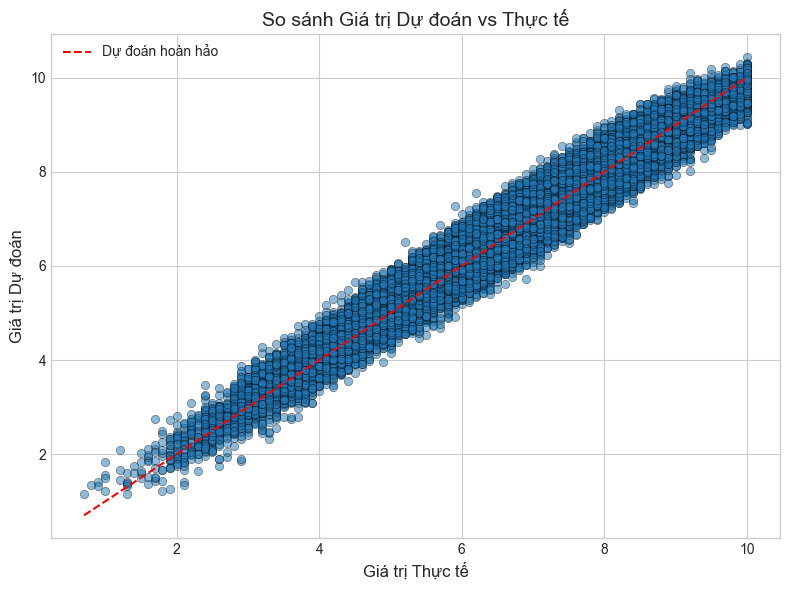

In [42]:
# Dự đoán lại để vẽ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytorch_model.eval()
pytorch_model.to(device)

predictions = []
with torch.no_grad():
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        out1, _ = pytorch_model(X_batch)
        predictions.append(out1.cpu().numpy())

y_pred_np = np.vstack(predictions).squeeze()
y_true_np = y_test.values if hasattr(y_test, 'values') else y_test

# Trực quan hóa
plot_predictions(y_true_np, y_pred_np)


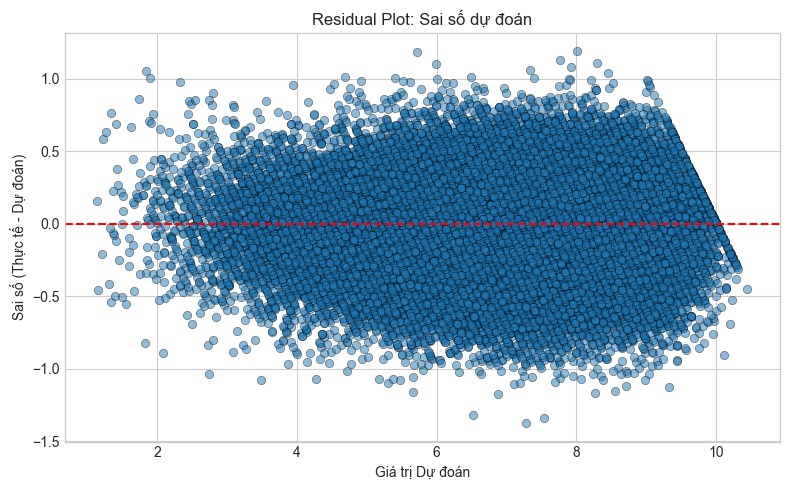

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_true_np - y_pred_np

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_np, y=residuals, alpha=0.5, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot: Sai số dự đoán')
plt.xlabel('Giá trị Dự đoán')
plt.ylabel('Sai số (Thực tế - Dự đoán)')
plt.grid(True)
plt.tight_layout()
plt.show()


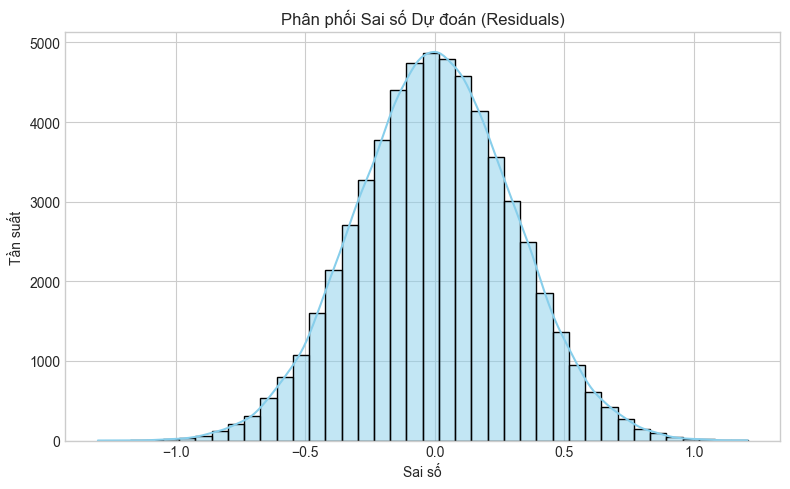

In [46]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=40, kde=True, color='skyblue')
plt.title('Phân phối Sai số Dự đoán (Residuals)')
plt.xlabel('Sai số')
plt.ylabel('Tần suất')
plt.grid(True)
plt.tight_layout()
plt.show()


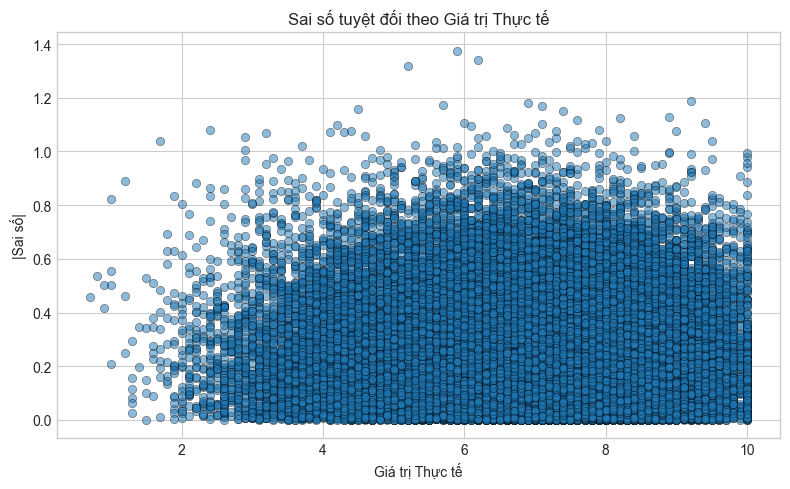

In [44]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_true_np, y=np.abs(residuals), alpha=0.5, edgecolor='k')
plt.title('Sai số tuyệt đối theo Giá trị Thực tế')
plt.xlabel('Giá trị Thực tế')
plt.ylabel('|Sai số|')
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
# Lưu trọng số (state_dict) của mô hình
torch.save(pytorch_model.state_dict(), "pytorch_model_weights.pth")


In [46]:
# Khởi tạo lại mô hình với kiến trúc giống cũ
model_loaded = MultitaskResNet(input_dim=input_dim)
model_loaded.load_state_dict(torch.load("pytorch_model_weights.pth"))
model_loaded.eval()


MultitaskResNet(
  (shared): Sequential(
    (0): Linear(in_features=76, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (out1): Linear(in_features=64, out_features=1, bias=True)
  (out2): Linear(in_features=64, out_features=1, bias=True)
)

In [47]:
import joblib

# Lưu cả mô hình (sẽ không đảm bảo an toàn)
joblib.dump(pytorch_model, "pytorch_model.joblib")

# Tải lại
model_loaded = joblib.load("pytorch_model.joblib")


In [48]:
# === Lưu trọng số của mô hình đã huấn luyện ===
torch.save(pytorch_model.state_dict(), "multitask_resnet_weights.pth")
print("✅ Đã lưu trọng số mô hình vào 'multitask_resnet_weights.pth'")


✅ Đã lưu trọng số mô hình vào 'multitask_resnet_weights.pth'


In [49]:
# === Tải lại mô hình với kiến trúc đúng ===
# (Bạn phải cung cấp input_dim giống như khi train ban đầu)
input_dim = X_train.shape[1]
model_loaded = MultitaskResNet(input_dim=input_dim)

# Tải trọng số
model_loaded.load_state_dict(torch.load("multitask_resnet_weights.pth"))
model_loaded.eval()

print("✅ Đã tải lại mô hình từ file và chuyển sang chế độ eval()")


✅ Đã tải lại mô hình từ file và chuyển sang chế độ eval()


In [50]:
# Dự đoán lại từ mô hình đã load
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_loaded.to(device)

model_loaded.eval()
preds = []

with torch.no_grad():
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        pred, _ = model_loaded(X_batch)
        preds.append(pred.cpu().numpy())

y_pred_loaded = np.vstack(preds).squeeze()

# So sánh lại
from sklearn.metrics import r2_score
r2_loaded = r2_score(y_test, y_pred_loaded)
print(f"🎯 R² Score từ mô hình đã tải lại: {r2_loaded:.4f}")


🎯 R² Score từ mô hình đã tải lại: 0.9569
